# Can you find a better way to segment your customers?

## 📖 Motivation (Kyra) 
You work for a medical device manufacturer in Switzerland. Your company manufactures orthopedic devices and sells them worldwide. The company sells directly to individual doctors who use them on rehabilitation and physical therapy patients.

Historically, the sales and customer support departments have grouped doctors by geography. However, the region is not a good predictor of the number of purchases a doctor will make or their support needs.

Your team wants to use a data-centric approach to segmenting doctors to improve marketing, customer service, and product planning. 



Questions to answer:
1. How many doctors are there in each region? What is the average number of purchases per region?
 - 9.5 doctors per region on average, 102 purchases per region on average
2. Can you find a relationship between purchases and complaints?
 - If there is, it isn't linear 
3. Define new doctor segments that help the company improve marketing efforts and customer service.
4. Identify which features impact the new segmentation strategy the most.
5. Your team will need to explain the new segments to the rest of the company. Describe which characteristics distinguish the newly defined segments.

## Related Work (Michael)

## 💾 The data & Data Wrangling ()

The company stores the information you need in the following four tables. Some of the fields are anonymized to comply with privacy regulations.

#### Doctors contains information on doctors. Each row represents one doctor.
- "DoctorID" - is a unique identifier for each doctor.
- "Region" - the current geographical region of the doctor.
- "Category" - the type of doctor, either 'Specialist' or 'General Practitioner.'
- "Rank" - is an internal ranking system. It is an ordered variable: The highest level is Ambassadors, followed by Titanium Plus, Titanium, Platinum Plus, Platinum, Gold Plus, Gold, Silver Plus, and the lowest level is Silver.
- "Incidence rate"  and "R rate" - relate to the amount of re-work each doctor generates.
- "Satisfaction" - measures doctors' satisfaction with the company.
- "Experience" - relates to the doctor's experience with the company.
- "Purchases" - purchases over the last year.

#### Orders contains details on orders. Each row represents one order; a doctor can place multiple orders.
- "DoctorID" - doctor id (matches the other tables).
- "OrderID" - order identifier.
- "OrderNum" - order number.
- "Conditions A through J" - map the different settings of the devices in each order. Each order goes to an individual patient.

#### Complaints collects information on doctor complaints.
- "DoctorID" - doctor id (matches the other tables).
- "Complaint Type" - the company's classification of the complaints.
- "Qty" - number of complaints per complaint type per doctor.

#### Instructions has information on whether the doctor includes special instructions on their orders.
- "DoctorID" - doctor id (matches the other tables).
- "Instructions" - 'Yes' when the doctor includes special instructions, 'No' when they do not.

### Setup

In [58]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
from pprint import pprint

import statsmodels.api as sm

from sklearn.impute import KNNImputer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import KernelPCA, PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer

### Data

In [2]:
#Read in all four at once
doctors = pd.read_csv('data/doctors.csv')
orders = pd.read_csv('data/orders.csv')
complaints = pd.read_csv('data/complaints.csv')
instructions = pd.read_csv('data/instructions.csv')

#### Doctors dataframe

In [3]:
doctors = pd.read_csv('data/doctors.csv')
doctors

,DoctorID,Region,Category,Rank,Incidence rate,R rate,Satisfaction,Experience,Purchases
0,AHDCBA,4 15,Specialist,Ambassador,49.00,0.90,53.85,1.20,49.0
1,ABHAHF,1 8 T4,General Practitioner,Ambassador,37.00,0.00,100.00,0.00,38.0
2,FDHFJ,1 9 T4,Specialist,Ambassador,33.00,1.53,--,0.00,34.0
3,BJJHCA,1 10 T3,Specialist,Ambassador,28.00,2.03,--,0.48,29.0
4,FJBEA,1 14 T4,Specialist,Ambassador,23.00,0.96,76.79,0.75,24.0
...,...,...,...,...,...,...,...,...,...
432,AIABDJ,1 10,Specialist,Ambassador,2.18,0.80,11.76,0.77,35.0
433,BBAJCF,1 9 T4,Specialist,Ambassador,2.17,1.68,--,0.11,19.0
434,GGCFB,1 19 T4,Specialist,Ambassador,2.14,0.77,--,0.27,22.0
435,FDCEG,1 9,Specialist,Ambassador,2.13,0.84,100.00,0.32,25.0


After taking an initial look at the doctors dataframe, we can break it down by column to see that most of the doctors (about 84%) are specialists. There are very few Gold, Silver and Titanium Plus ranks; the most common rank is Ambassador. There are 46 different regions. The "1 13" region has the most doctors (34), followed closely by the "1 9", "1 14" and "1 19" regions.

In [4]:
#367 specialists, 70 GPs
doctors['Category'].value_counts()

#Most are ambassador, with fair amount of platinum, titanium, platinum plus, gold plus, silver plus and few gold, silver or titanium plus
doctors['Rank'].value_counts()

#46 different regions
doctors['Region'].value_counts()
doctors['Region'].nunique()

46

[Text(0.5, 1.0, 'Doctors in Each Region')]

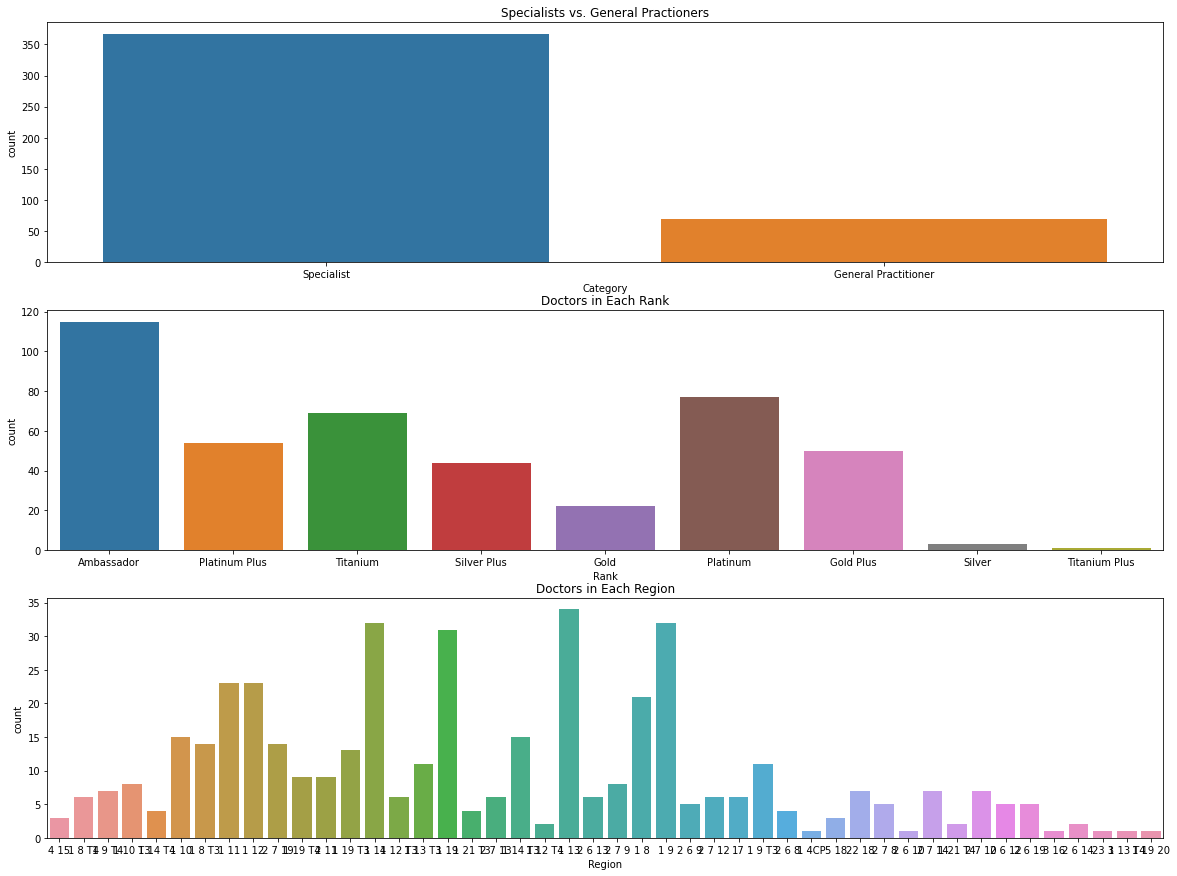

In [5]:
#Visualizing the above.
f1, axs = plt.subplots(3,1, figsize = (20, 15))
sns.countplot(data = doctors, x = 'Category', ax = axs[0]).set(title = 'Specialists vs. General Practioners')
sns.countplot(data = doctors, x = 'Rank', ax = axs[1]).set(title = 'Doctors in Each Rank')
sns.countplot(data = doctors, x = 'Region', ax = axs[2]).set(title = 'Doctors in Each Region')

In [6]:
def clean_satisfaction(sat):
    if sat == '--':
        sat = np.nan
    else:
        sat = float(sat)
    return sat

doctors['Satisfaction'] = doctors['Satisfaction'].apply(clean_satisfaction)

Before we take a look at the quantitative variables, we need to change the Satisfaction column to floats. We will replace the missing entries (denoted in the dataframe as '--') with np.nan using the function below. 

Having done this, we can take a peek at the distribution of the quantitative variables (Incidence rate, R rate, Satisfaction, Experience and Purchases). The mean *Incidence rate* is about 5, while the median is 4, so we can expect a slight right skew, which is probably accounted for by the large max of 49 (much higher than the third quartile, though definitely not an outlier). The mean for *R rate* is about one as is the median, so we can expect this distribution to be somewhat even, though again we can see that the max is a fair bit higher than the third quartile. The mean for *Satisfaction* is around 30 while the median is close to 40, we can expect a slight left skew in this distribution, which may be accounted by large negative values. The mean for *experience* is .53 while the median is .38, so again we can expect something of a right skew in this distribution, which may be accounted for by the max, which is significantly larger than the third quartile. Finally, the mean of *purchases* is around 10, while the median is 7. This again suggests a right skew, which may be accounted for by the large value of the max. 

In [7]:
doctors.describe()

,Incidence rate,R rate,Satisfaction,Experience,Purchases
count,437.000000,437.000000,250.000000,437.000000,437.000000
mean,5.049748,1.098627,29.218720,0.534027,10.791762
std,4.179639,0.731895,61.225893,0.603494,11.429686
min,2.050000,0.000000,-100.000000,0.000000,3.000000
25%,3.000000,0.600000,-12.315000,0.140000,4.000000
50%,4.000000,1.000000,39.230000,0.380000,7.000000
75%,6.000000,1.500000,83.330000,0.750000,13.000000
max,49.000000,4.250000,100.000000,5.420000,129.000000


For future use and manipulation, we convert the rank and category of the doctors to numbers. 

For rank, since there is an inherent hierarchy we can order them from 1-9, with the highest rank, Ambassador, being 9 and the lowest rank, Silver, being 1. It should be noted that there are two entries in the dataframe where the rank is unknown, denoted now by np.nan.

For category, since there are so many specialists, we will use a boolean sort of system. Specialists will be denoted as 1 and general practitioners will be denoted by 0.

In [8]:
#converting string data into numbers 

def transform_rank(rank):
    ###Takes name of doctor's rank and transforms it into ordinal data from 1-9
    if rank == 'Ambassador':
        num_rank = 9
    elif rank == 'Titanium Plus':
        num_rank = 8
    elif rank == 'Titanium':
        num_rank = 7
    elif rank == 'Platinum Plus':
        num_rank = 6
    elif rank == 'Platinum':
        num_rank = 5
    elif rank == 'Gold Plus':
        num_rank = 4
    elif rank == 'Gold':
        num_rank = 3
    elif rank == 'Silver Plus':
        num_rank = 2
    elif rank == 'Silver':
        num_rank = 1
    else:
        num_rank = np.nan
    return num_rank

def conv_cat_to_num(cat):
    ###Takes category of doctor and returns 1 if specialist and 0 if GP
    if cat == 'Specialist':
        cat = 1
    elif cat == 'General Practitioner':
        cat = 0
    else:
        cat = np.nan
    return cat

#apply to doctors dataframe
doctors['Rank'] = doctors['Rank'].apply(transform_rank)
doctors['Category'] = doctors['Category'].apply(conv_cat_to_num)

doctors.head()

,DoctorID,Region,Category,Rank,Incidence rate,R rate,Satisfaction,Experience,Purchases
0,AHDCBA,4 15,1,9.0,49.0,0.90,53.85,1.20,49.0
1,ABHAHF,1 8 T4,0,9.0,37.0,0.00,100.00,0.00,38.0
2,FDHFJ,1 9 T4,1,9.0,33.0,1.53,NaN,0.00,34.0
3,BJJHCA,1 10 T3,1,9.0,28.0,2.03,NaN,0.48,29.0
4,FJBEA,1 14 T4,1,9.0,23.0,0.96,76.79,0.75,24.0


##### Calculating average number of doctors and purchases per region:
Since the company has traditionally relied on region to cluster doctors, we first investigated the relationship between region and purchases. This was undertaken by totaling up the number od doctors in each region and then totaling up the purchases of each doctor in that region. We were then able to take the mean of each of these columns to find that there are, on average, 9.5 doctors per region and 102.5 purchases per region.

In [9]:
#Make separate dataframe for just region counts
doc_count = pd.DataFrame(doctors['Region'].value_counts())
doc_count.index.name = 'Region'
doc_count.columns = ['Total Doctors']

#Make separate dataframe for total purchases by region
doc_purch_sum = pd.DataFrame(doctors['Purchases'].groupby(doctors['Region']).sum())
doc_purch_sum.index.name = 'Region'
doc_purch_sum.columns = ['Total Purchases']

#Join two dataframes together 
region_merged = doc_count.merge(doc_purch_sum, how = 'outer', on = 'Region')
region_merged

print(region_merged.head())
print('The mean number of doctors per region is ', region_merged['Total Doctors'].mean(), ' doctors.')
print('The mean number of purchases per region is ', region_merged['Total Purchases'].mean(), ' purchases.')

        Total Doctors  Total Purchases
Region                                
1 13               34            353.0
1 9                32            346.0
1 14               32            389.0
1 19               31            281.0
1 11               23            243.0
The mean number of doctors per region is  9.5  doctors.
The mean number of purchases per region is  102.52173913043478  purchases.


,Total Doctors,Total Purchases
count,46.000000,46.000000
mean,9.500000,102.521739
std,9.008021,107.710670
min,1.000000,5.000000
25%,4.000000,25.250000
50%,6.000000,48.500000
75%,12.500000,149.750000
max,34.000000,389.000000


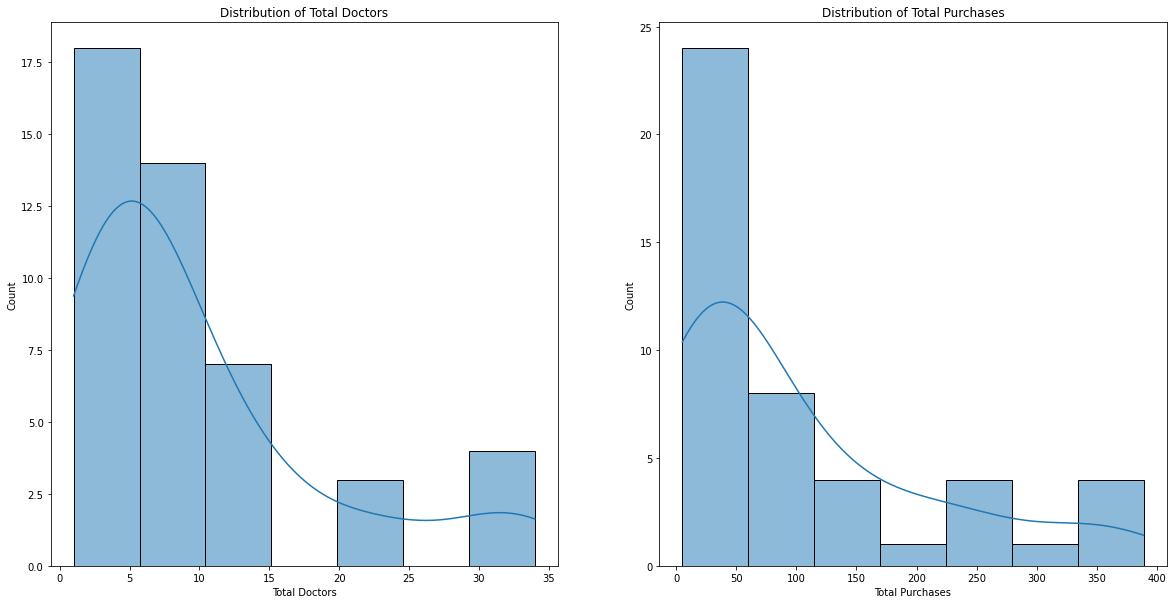

In [10]:
#Let's visualize the distribution of doctors per region
f2, axs = plt.subplots(1, 2, figsize = (20, 10))
sns.histplot(data = region_merged, x = 'Total Doctors', kde= True, ax = axs[0]).set(title = 'Distribution of Total Doctors')
sns.histplot(data = region_merged, x = 'Total Purchases', kde= True, ax = axs[1]).set(title = 'Distribution of Total Purchases')
region_merged.describe()

Above, we visualized the distribution for both total doctors per region and total purchases per region. With these graphs, as well as with the descriptive statistics printed above, we can see that both distributions have a right skew, with their means being larger than their medians.

Therefore, when we investigated linear relationships between the two distributions below we applied a log10 transformation. Using ordinary least squares, we found a correlation of about .915, suggesting a very strong positive correlation. It should be noted however, the middling R-squared value (.623), and that while it does seem to be true that the regions with the most doctors yield the most purchases this is more a measure of doctor density than a strategic data-driven approach based on the individual doctors themselves. Finding a more targeted approach at the individual level should help all regions to yield more purchases.

In [11]:
region_merged.rename(columns = {'Total Purchases' : 'TP', 'Total Doctors' : 'TD'}, inplace = True)
region_merged
region_merged['TP_log10'] = region_merged['TP'].apply(np.log10)
region_merged['TD_log10'] = region_merged['TD'].apply(np.log10)
res_1 = sm.OLS.from_formula(formula = 'TP_log10 ~ TD_log10', data = region_merged).fit()
print(res_1.summary())


                            OLS Regression Results                            
Dep. Variable:               TP_log10   R-squared:                       0.623
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     72.85
Date:                Tue, 29 Nov 2022   Prob (F-statistic):           6.97e-11
Time:                        19:40:46   Log-Likelihood:                -11.205
No. Observations:                  46   AIC:                             26.41
Df Residuals:                      44   BIC:                             30.07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.0353      0.096     10.760      0.0

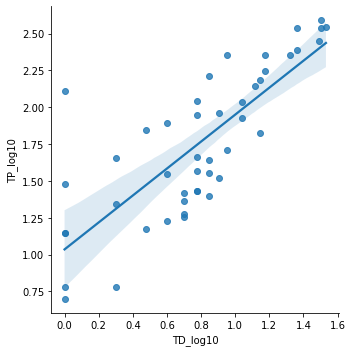

In [12]:
sns.lmplot(data = region_merged, x = 'TD_log10', y = 'TP_log10')

#### Orders dataframe

In [13]:
orders = pd.read_csv('data/orders.csv')
orders

,DoctorID,OrderID,OrderNum,Condition A,Condition B,Condition C,Condition D,Condition F,Condition G,Condition H,Condition I,Condition J
0,ABJEAI,DGEJFDC,AIBEHCJ,False,False,False,False,False,True,True,False,Before
1,HBIEA,DGAJDAH,AIJIHGB,False,True,NaN,False,False,True,False,True,Before
2,GGCCD,DGBBDCB,AFEIHFB,False,False,False,False,False,False,False,False,NaN
3,EHHGF,DGCDCCF,AIBJJEE,False,False,False,True,False,False,True,False,Before
4,EHHGF,DGCFAGC,AEDBBDC,False,False,False,False,False,False,False,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
252,FJFEG,DGDBGJH,AIBCDCE,False,True,False,False,False,True,True,False,Before
253,FJFEG,DGDBGGI,AIBCDGD,False,False,True,False,False,False,True,False,Before
254,FJFEG,DGEABGI,AIBFJHE,True,False,False,False,False,False,False,False,Before
255,FJFEG,DGEABGI,AIBFJHE,True,False,False,True,False,False,False,False,Before


Taking an initial look at the orders dataframe, we can see that the same doctors occur multiple times in this dataframe. Using value_counts and .describe(), we can see that there are actually only 76 individual doctors represented here as compared to the 437 in the doctors dataframe. On average, the doctors in this dataframe made about 3 orders. There is a pretty large range of 18, with the max (19) being much larger than the third quartile (4). However, with the large amount of points at 1, the median is actually lower than the mean.

We will need to keep the fact that individual doctors are represented multiple times in mind when we compare this dataframe with doctors.

In [14]:
ords_per_doc = orders['DoctorID'].value_counts()
print(ords_per_doc.describe())

orders['DoctorID'].value_counts()

count    76.000000
mean      3.381579
std       3.773476
min       1.000000
25%       1.000000
50%       2.000000
75%       4.000000
max      19.000000
Name: DoctorID, dtype: float64


AAAEAH    19
FAHDI     17
AFCADC    15
FBFHB     14
FAGIE     11
          ..
ADFECC     1
HBAHA      1
GDADF      1
AHDDAI     1
AIABDJ     1
Name: DoctorID, Length: 76, dtype: int64

In [15]:
#Now because each doctor potentially occurs multiple times, we need to make a dataframe to reassign so singular doctors
ords_per_doc = pd.DataFrame(ords_per_doc)
ords_per_doc.index.name = 'DoctorID'
ords_per_doc.columns = ['Orders']
ords_per_doc.reset_index(inplace=True)
ords_per_doc

,DoctorID,Orders
0,AAAEAH,19
1,FAHDI,17
2,AFCADC,15
3,FBFHB,14
4,FAGIE,11
...,...,...
71,ADFECC,1
72,HBAHA,1
73,GDADF,1
74,AHDDAI,1


To begin cleaning this data, we will convert the True/False values in conditions A-I to 1s and 0s. We will also convert condition J so that before is 0 and after is 1, preserving the same sort of ratios to True/Falses we see in the other conditions.

In [16]:
def conv_to_number(str_in):
    if str_in == True:
        result = 1
    elif str_in == False:
        result = 0
    else:
        result = np.nan
    return result

def condJ_conv_to_number(str_in):
    if str_in == 'Before':
        result = 0
    elif str_in == 'After':
        result = 1
    else:
        result = np.nan
    return result

conditions = ['Condition A', 'Condition B', 'Condition C', 'Condition D', 'Condition F', 'Condition G', 'Condition H', 'Condition I', 'Condition J']
for col in conditions[:-1]:
    orders[col] = orders[col].apply(conv_to_number)

orders['Condition J'] = orders['Condition J'].apply(condJ_conv_to_number)
    
orders.head()

,DoctorID,OrderID,OrderNum,Condition A,Condition B,Condition C,Condition D,Condition F,Condition G,Condition H,Condition I,Condition J
0,ABJEAI,DGEJFDC,AIBEHCJ,0,0,0.0,0,0.0,1.0,1,0,0.0
1,HBIEA,DGAJDAH,AIJIHGB,0,1,NaN,0,0.0,1.0,0,1,0.0
2,GGCCD,DGBBDCB,AFEIHFB,0,0,0.0,0,0.0,0.0,0,0,NaN
3,EHHGF,DGCDCCF,AIBJJEE,0,0,0.0,1,0.0,0.0,1,0,0.0
4,EHHGF,DGCFAGC,AEDBBDC,0,0,0.0,0,0.0,0.0,0,0,NaN


Having done this, we can that the manipulations on each category 

In [17]:
orders.describe()

,Condition A,Condition B,Condition C,Condition D,Condition F,Condition G,Condition H,Condition I,Condition J
count,257.000000,257.000000,248.000000,257.000000,254.000000,254.000000,257.000000,257.000000,149.000000
mean,0.128405,0.140078,0.125000,0.132296,0.003937,0.181102,0.284047,0.073930,0.013423
std,0.335193,0.347745,0.331388,0.339473,0.062746,0.385863,0.451839,0.262167,0.115465
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [18]:
#Now because each doctor potentially occurs multiple times, we need to make a dataframe to reassign so singular doctors
doc_IDs = orders['DoctorID'].unique()
doc_IDS = list(doc_IDs)
ord_per_doc = pd.DataFrame(doc_IDs)
ord_per_doc.columns = ['DoctorID']

for cond in conditions:
    ord_per_doc[cond] = 0
    
ord_per_doc

temp_df = orders[orders['DoctorID'] == 'AAAEAH']
temp_df

for ID in doc_IDs:
    temp_df = orders[orders['DoctorID'] == ID]
    total_A = temp_df['Condition A'].sum()
    total_B = temp_df['Condition B'].sum()
    total_C = temp_df['Condition C'].sum()
    total_D = temp_df['Condition D'].sum()
    total_F = temp_df['Condition F'].sum()
    total_G = temp_df['Condition G'].sum()
    total_H = temp_df['Condition H'].sum()
    total_I = temp_df['Condition I'].sum()
    total_J = temp_df['Condition J'].sum()
    
    index = ord_per_doc.index[ord_per_doc['DoctorID'] == ID].tolist()[0]
    ord_per_doc.iloc[index, 1] = total_A
    ord_per_doc.iloc[index, 2] = total_B
    ord_per_doc.iloc[index, 3] = total_C
    ord_per_doc.iloc[index, 4] = total_D
    ord_per_doc.iloc[index, 5] = total_F
    ord_per_doc.iloc[index, 6] = total_G
    ord_per_doc.iloc[index, 7] = total_H
    ord_per_doc.iloc[index, 8] = total_I
    ord_per_doc.iloc[index, 9] = total_J
    
    

In [19]:
ord_per_doc

,DoctorID,Condition A,Condition B,Condition C,Condition D,Condition F,Condition G,Condition H,Condition I,Condition J
0,ABJEAI,0,0,0,0,0,1,1,0,0
1,HBIEA,0,1,0,0,0,1,0,1,0
2,GGCCD,0,0,0,0,0,0,0,0,0
3,EHHGF,0,1,0,1,0,0,1,0,0
4,FCBDC,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
71,BJEACG,0,0,0,0,0,0,0,0,0
72,FJGEJ,1,0,1,1,0,1,1,2,0
73,GDGHI,1,0,0,0,0,0,0,0,0
74,FJFEG,2,1,1,1,0,1,2,0,0


#### Complaints Dataframe

In [20]:
complaints = pd.read_csv('data/complaints.csv')
complaints

,DoctorID,Complaint Type,Qty
0,EHAHI,Correct,10
1,EHDGF,Correct,2
2,EHDGF,Unknown,3
3,EHDIJ,Correct,8
4,EHDIJ,Incorrect,2
...,...,...,...
430,BHGIFC,Incorrect,1
431,BHHDDF,Correct,1
432,CJAFAB,Incorrect,1
433,CAAHID,Correct,2


In [21]:
complaints.dtypes
complaints['Complaint Type'].value_counts()
#complaints.describe()

# complaints['DoctorID'].value_counts().describe()

Correct      205
Incorrect    118
Unknown      103
Specific       6
R&R            1
Name: Complaint Type, dtype: int64

In [22]:
#To answer question need to match up purchases and complaints. We could do this by taking doctors IDs and purchases from doctors dataframe
#and complaint data from complaints. We know that single doctors are listed multiple times for complaints, under different categories. This may 
#be important information to preserve... but how to do that?

# print(complaints['DoctorID'].value_counts())
#We'll start by taking a look at those doctors with multiple entries to see what exactly that means
complaints[complaints['DoctorID'] == 'AAEIEG']

#What I think I need to do is group by doctor and then by complaint type...
comp_group = pd.DataFrame(complaints['Complaint Type'].groupby(complaints['DoctorID']).value_counts())
comp_group
#OK so this got closer to what I was envisioning, but value counts is not the right thing to call here. We need to get the value of Qty in the last column

# comp_group[comp_group['DoctorID'] == 'AAEIEG']
complaints[complaints['DoctorID'] == 'AAEIEG']
complaints.sort_values('DoctorID')

,DoctorID,Complaint Type,Qty
216,AAAEAH,Correct,1
217,AAAHCE,Correct,1
219,AAAHCE,Unknown,1
218,AAAHCE,Incorrect,2
220,AABDHC,Incorrect,1
...,...,...,...
201,IEJIA,Unknown,1
203,IFBHI,Incorrect,1
204,IFBHI,Unknown,1
205,IFDIB,Correct,1


In [23]:
#Get total complaints for each doctor

#get list of doctor IDS
doc_IDs = complaints['DoctorID'].unique()
doc_IDs
doc_IDs = list(doc_IDs)

#make a dataframe we can add the info to
comp_per_doc = pd.DataFrame(doc_IDs)
comp_per_doc.columns = ['DoctorID']
comp_per_doc['Total Complaints'] = 0


#translate complaints into a more useable format
for ID in doc_IDs:
    # print(ID)
    temp_df = complaints[complaints['DoctorID'] == ID]
    # print(temp_df)
    total_comp = temp_df['Qty'].sum()
    # print(total_comp)
    index = comp_per_doc.index[comp_per_doc['DoctorID'] == ID].tolist()[0]
    # print(index)
    comp_per_doc.iloc[index, 1] = total_comp

    
comp_per_doc

,DoctorID,Total Complaints
0,EHAHI,10
1,EHDGF,5
2,EHDIJ,13
3,EHDIC,3
4,EHDIH,1
...,...,...
279,BHGIFC,3
280,BHHDDF,1
281,CJAFAB,1
282,CAAHID,2


In [24]:
###LETS FIX THIS
# print(complaints['Complaint Type'].unique())
#Complaints can be of 5 types ('Correct', 'Unknown', 'Incorrect', 'Specific' and 'R&R'), and some have null values.
comp_per_doc['Correct'] = 0
comp_per_doc['Unknown'] = 0
comp_per_doc['Incorrect'] = 0
comp_per_doc['Specific'] = 0
comp_per_doc['R&R'] = 0
comp_per_doc['null'] = 0
# print(comp_per_doc.head())

In [25]:
#Fill in the values
for ID in doc_IDs:
    index = comp_per_doc.index[comp_per_doc['DoctorID'] == ID].tolist()[0]
    temp_df = complaints[complaints['DoctorID'] == ID]
    for ind in temp_df.index:
        if temp_df['Complaint Type'][ind] == 'Correct':
            val = temp_df['Qty'][ind]
            comp_per_doc.iloc[index, 2] = val
        elif temp_df['Complaint Type'][ind] == 'Incorrect':
            val = temp_df['Qty'][ind]
            comp_per_doc.iloc[index, 4] = val
        elif temp_df['Complaint Type'][ind] == 'R&R':
            val = temp_df['Qty'][ind]
            comp_per_doc.iloc[index, 6] = val
        elif temp_df['Complaint Type'][ind] == 'Unknown':
            val = temp_df['Qty'][ind]
            comp_per_doc.iloc[index, 3] = val
        elif temp_df['Complaint Type'][ind] == 'Specific':
            val = temp_df['Qty'][ind]
            comp_per_doc.iloc[index, 5] = val
        else:
            val = temp_df['Qty'][ind]
            comp_per_doc.iloc[index, 7] = val

comp_per_doc

,DoctorID,Total Complaints,Correct,Unknown,Incorrect,Specific,R&R,null
0,EHAHI,10,10,0,0,0,0,0
1,EHDGF,5,2,3,0,0,0,0
2,EHDIJ,13,8,3,2,0,0,0
3,EHDIC,3,0,0,3,0,0,0
4,EHDIH,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...
279,BHGIFC,3,2,0,1,0,0,0
280,BHHDDF,1,1,0,0,0,0,0
281,CJAFAB,1,0,0,1,0,0,0
282,CAAHID,2,2,0,0,0,0,0


In [26]:
comp_per_doc.describe()

,Total Complaints,Correct,Unknown,Incorrect,Specific,R&R,null
count,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000
mean,2.746479,1.588028,0.510563,0.609155,0.028169,0.003521,0.007042
std,2.934952,2.021789,0.934173,0.923995,0.203977,0.059339,0.083770
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,20.000000,15.000000,8.000000,4.000000,2.000000,1.000000,1.000000


In [27]:
#Merging with the total purchases per doctor for visualization
comp_plus_purch = comp_per_doc.merge(doctors, how = 'inner', on = 'DoctorID')
comp_plus_purch = comp_plus_purch[['DoctorID', 'Total Complaints', 'Correct', 'Unknown', 'Incorrect', 'Specific', 'R&R', 'null', 'Purchases']]
comp_plus_purch

comp_plus_purch.describe()

,Total Complaints,Correct,Unknown,Incorrect,Specific,R&R,null,Purchases
count,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.0,74.000000
mean,3.594595,1.986486,0.635135,0.891892,0.067568,0.013514,0.0,15.540541
std,3.748676,2.480020,1.041263,1.244908,0.344470,0.116248,0.0,19.368234
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,3.000000
25%,1.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.0,5.000000
50%,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,9.000000
75%,5.750000,3.000000,1.000000,1.000000,0.000000,0.000000,0.0,17.500000
max,20.000000,15.000000,6.000000,4.000000,2.000000,1.000000,0.0,129.000000


<AxesSubplot:xlabel='Purchases', ylabel='Count'>

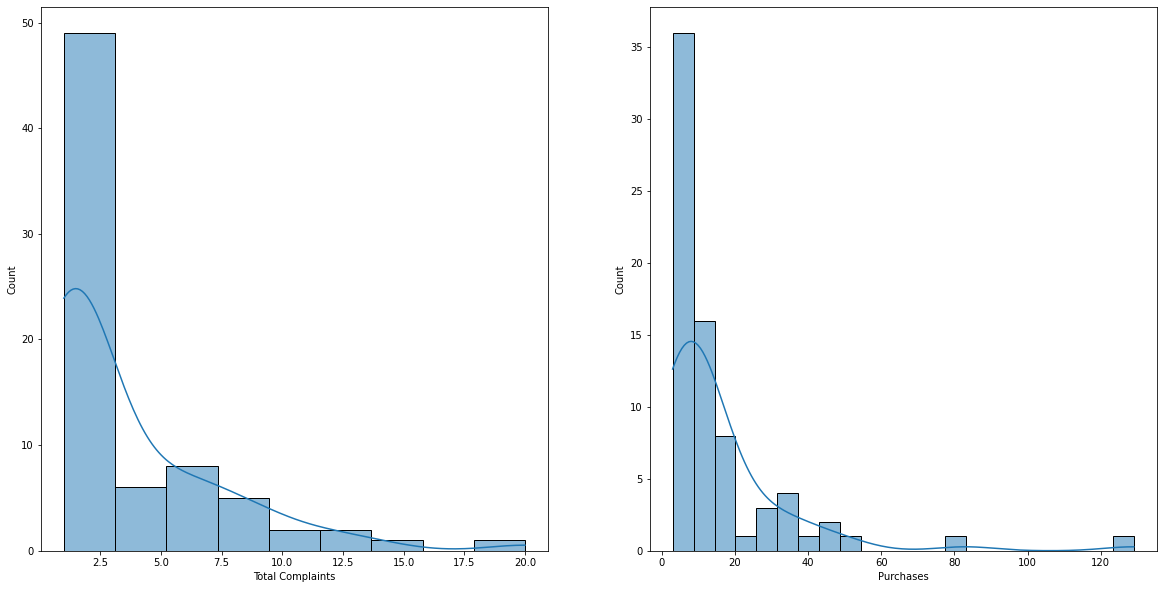

In [28]:
f3, axs = plt.subplots(1, 2, figsize = (20, 10))
sns.histplot(data = comp_plus_purch, x = 'Total Complaints', kde = True, ax = axs[0])
sns.histplot(data = comp_plus_purch, x = 'Purchases', kde = True, ax = axs[1])



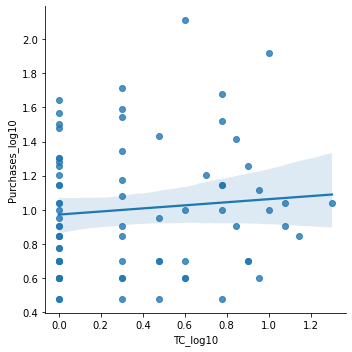

In [29]:
comp_plus_purch['TC_log10'] = comp_plus_purch['Total Complaints'].apply(np.log10)
comp_plus_purch['Purchases_log10'] = comp_plus_purch['Purchases'].apply(np.log10)
sns.lmplot(data = comp_plus_purch, x = 'TC_log10', y = 'Purchases_log10')

Complaint Type
Correct      205
Incorrect    118
Unknown      103
Specific       6
R&R            1
dtype: int64


[Text(0.5, 1.0, 'null')]

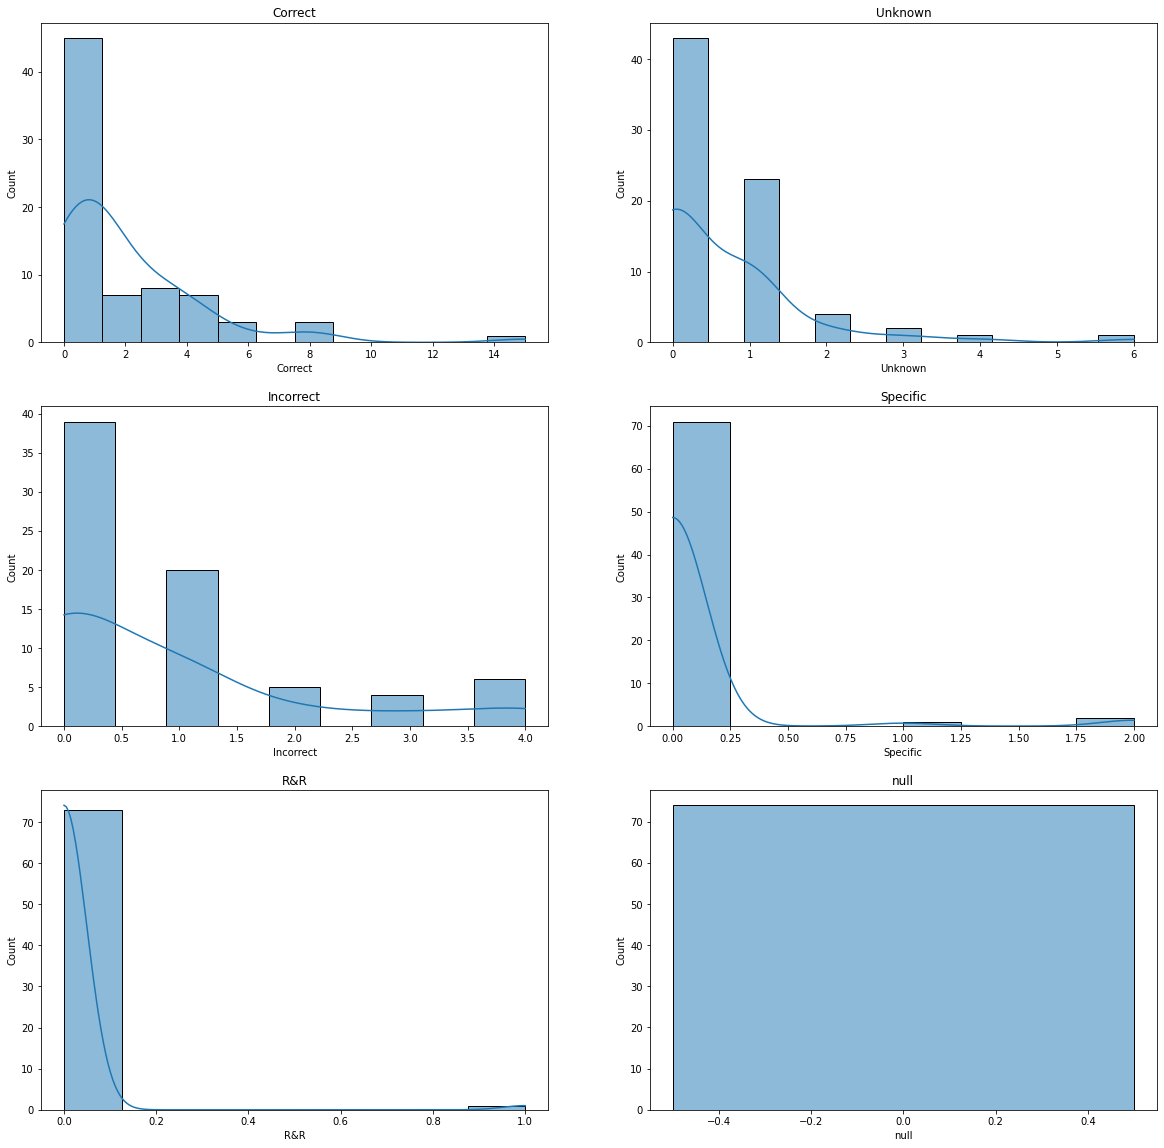

In [30]:
print(complaints.value_counts('Complaint Type'))

f4, axs = plt.subplots(3, 2, figsize = (20, 20))
sns.histplot(data = comp_plus_purch, x = 'Correct', kde = True, ax = axs[0, 0]).set(title = 'Correct')
sns.histplot(data = comp_plus_purch, x = 'Unknown', kde = True, ax = axs[0, 1]).set(title = 'Unknown')
sns.histplot(data = comp_plus_purch, x = 'Incorrect', kde = True, ax = axs[1, 0]).set(title = 'Incorrect')
sns.histplot(data = comp_plus_purch, x = 'Specific', kde = True, ax = axs[1, 1]).set(title = 'Specific')
sns.histplot(data = comp_plus_purch, x = 'R&R', kde = True, ax = axs[2, 0]).set(title = 'R&R')
sns.histplot(data = comp_plus_purch, x = 'null', kde = True, ax = axs[2, 1]).set(title = 'null')

#### Instructions dataframe

In [31]:
instructions = pd.read_csv('data/instructions.csv')
instructions

,DoctorID,Instructions
0,ADIFBD,Yes
1,ABHBED,No
2,FJFEG,Yes
3,AEBDAB,No
4,AJCBFE,Yes
...,...,...
72,ABEAFF,Yes
73,FCGCI,Yes
74,FBAHD,Yes
75,FCABB,Yes


In [32]:
instructions['Instructions'].value_counts()
# instructions['DoctorID'].value_counts()

Yes    67
No     10
Name: Instructions, dtype: int64

In [33]:
#Convert yes and no to numbers DO NOT RUN MULTIPLE TIMES
def instr_conv_to_number(str_in):
    if str_in == 'Yes':
        result = 1
    elif str_in == 'No':
        result = 0
    else:
        result = np.nan
    return result

instructions['Instructions'] = instructions['Instructions'].apply(instr_conv_to_number)


In [34]:
instructions
instructions.describe()

,Instructions
count,77.000000
mean,0.870130
std,0.338365
min,0.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,1.000000


#### Joining the dataframes together

In [35]:
#Four dataframes that need to be merged: doctors, ords_per_doc, comp_per_doc and instructions
doc_merged = doctors.merge(comp_per_doc, how = 'left', on = 'DoctorID')
doc_merged = doc_merged.merge(ords_per_doc, how = 'left', on = 'DoctorID')
doc_merged = doc_merged.merge(instructions, how = 'left', on = 'DoctorID')

doc_merged = doc_merged [['DoctorID', 'Satisfaction', 'Category', 'Incidence rate', 'R rate', 'Experience', 'Purchases', 'Total Complaints', 'Orders', 'Instructions']]
doc_merged

,DoctorID,Satisfaction,Category,Incidence rate,R rate,Experience,Purchases,Total Complaints,Orders,Instructions
0,AHDCBA,53.85,1,49.00,0.90,1.20,49.0,NaN,NaN,1.0
1,ABHAHF,100.00,0,37.00,0.00,0.00,38.0,NaN,NaN,NaN
2,FDHFJ,NaN,1,33.00,1.53,0.00,34.0,NaN,NaN,NaN
3,BJJHCA,NaN,1,28.00,2.03,0.48,29.0,NaN,NaN,NaN
4,FJBEA,76.79,1,23.00,0.96,0.75,24.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
432,AIABDJ,11.76,1,2.18,0.80,0.77,35.0,2.0,1.0,1.0
433,BBAJCF,NaN,1,2.17,1.68,0.11,19.0,1.0,2.0,NaN
434,GGCFB,NaN,1,2.14,0.77,0.27,22.0,NaN,NaN,1.0
435,FDCEG,100.00,1,2.13,0.84,0.32,25.0,NaN,NaN,NaN


We need Sat, Cat, Rrate, Irate, exp, cur purch, prev purch, tot complaints, instr

In [36]:
#appears to be 437 total doctors, but not all are represented in each dataframe
#also the above shows us that this problem is more complicated than I orginally assumed
#There are 17 DoctorIDs that are in all 4 dataFrames

print(doctors['DoctorID'].nunique(), orders['DoctorID'].nunique(), complaints['DoctorID'].nunique(), instructions['DoctorID'].nunique())
doc_uni = doctors['DoctorID'].unique()
ord_uni = orders['DoctorID'].unique()
comp_uni = complaints['DoctorID'].unique()
ins_uni = instructions['DoctorID'].unique()



437 76 284 77


## Clustering

### Data Imputation

In [37]:
df = doc_merged.drop(['DoctorID', 'Instructions'], axis=1)
df.info()
df.isnull().sum()
df.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 437 entries, 0 to 436
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Satisfaction      250 non-null    float64
 1   Category          437 non-null    int64  
 2   Incidence rate    437 non-null    float64
 3   R rate            437 non-null    float64
 4   Experience        437 non-null    float64
 5   Purchases         437 non-null    float64
 6   Total Complaints  74 non-null     float64
 7   Orders            74 non-null     float64
dtypes: float64(7), int64(1)
memory usage: 30.7 KB


,Satisfaction,Category,Incidence rate,R rate,Experience,Purchases,Total Complaints,Orders
count,250.000000,437.000000,437.000000,437.000000,437.000000,437.000000,74.000000,74.000000
mean,29.218720,0.839817,5.049748,1.098627,0.534027,10.791762,3.594595,3.324324
std,61.225893,0.367196,4.179639,0.731895,0.603494,11.429686,3.748676,3.807376
min,-100.000000,0.000000,2.050000,0.000000,0.000000,3.000000,1.000000,1.000000
25%,-12.315000,1.000000,3.000000,0.600000,0.140000,4.000000,1.000000,1.000000
50%,39.230000,1.000000,4.000000,1.000000,0.380000,7.000000,2.000000,2.000000
75%,83.330000,1.000000,6.000000,1.500000,0.750000,13.000000,5.750000,4.000000
max,100.000000,1.000000,49.000000,4.250000,5.420000,129.000000,20.000000,19.000000


We have quite some missing data, we'll do data imputation to fill in the missing data for each feature

In [38]:
df['Total Complaints'] = df['Total Complaints'].fillna(0)
df['Orders'] = df['Orders'].fillna(0)

In [39]:
df['Satisfaction'] = KNNImputer(n_neighbors=4).fit_transform(np.array(df['Satisfaction'])[:, None])

In [40]:
df.isna().sum()

Satisfaction        0
Category            0
Incidence rate      0
R rate              0
Experience          0
Purchases           0
Total Complaints    0
Orders              0
dtype: int64

### Scalers 

Our categorical data have been one-hot-encoded, we only have to scale some of our numerical data

In [41]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer

class IdentityTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, input_array, y=None):
        return self
    
    def transform(self, input_array, y=None):
        return input_array*1

scaled_pipeline = Pipeline([
        ('std_scaler', StandardScaler()),
    ])
identity_pipeline = Pipeline([
        ('identity', IdentityTransformer()),
    ])
scaler = ColumnTransformer([
        ('scaled', scaled_pipeline, ["Satisfaction", "Incidence rate", "R rate", "Purchases", "Total Complaints", "Orders"]),
        ('identity', identity_pipeline, ["Experience", "Category"]),
    ])  # transform columnwise and feature is on 2nd dimension


### PCA 
We use reduce noise in the data and prevent curse of dimensionality when we use k-means later

In [42]:
pca = PCA(n_components=4, random_state=22)

We use 4 components for now, we'll fine tune it later in the notebook

#### Fine tune number of components of PCA

[0.23237584 0.18977132 0.15135773 0.14919473 0.107616   0.09668959
 0.05532241 0.01767238]
[0.23237584 0.42214716 0.57350489 0.72269962 0.83031562 0.92700521
 0.98232762 1.        ]


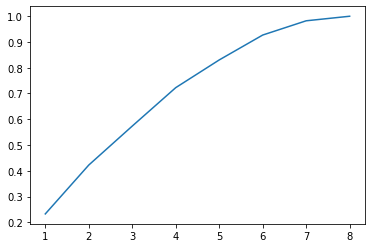

In [43]:
pca = PCA(n_components=len(df.columns), random_state=22)
pipe =  Pipeline([
           ('scaler', scaler),
           ('pca', pca)])
pipe.fit(df)
cumsum =np.cumsum(pca.explained_variance_ratio_)
ax = sns.lineplot(x=np.arange(1, len(df.columns) + 1) , y = cumsum)
print(pca.explained_variance_ratio_)
print(cumsum)

By the elbow method, both 4 and 5 components seem valid

### Clusterinig with K-means

#### Pick optimial number of clusters

In [44]:
sum_of_squared_distances = []
pca = PCA(n_components=4, random_state=22)
max_clusters = 10
for i in range(1, max_clusters):
    km = KMeans(n_clusters=i, init="k-means++", n_init=50, max_iter=500, random_state=22)
    clusterer = Pipeline([
               ('scaler', scaler),
               ('pca', pca),
               ('kmeans', km)])
    _ = clusterer.fit(df)
    sum_of_squared_distances.append(km.inertia_)

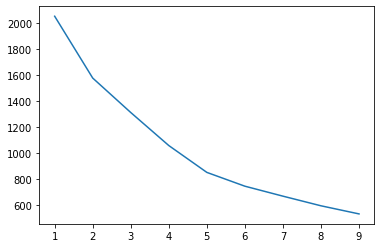

In [45]:
ax = sns.lineplot(x=np.arange(1, max_clusters) , y = sum_of_squared_distances)

4 clusters seem like a good candidate

#### RBF Kernel 
Let's try using RBF kernel for PCA to introduce nonlinearity

In [46]:
sum_of_squared_distances = []
pca = KernelPCA(n_components=4, random_state=22, kernel='rbf')
max_clusters = 10
for i in range(1, max_clusters):
    km = KMeans(n_clusters=i, init="k-means++", n_init=50, max_iter=500, random_state=22)
    clusterer = Pipeline([
               ('scaler', scaler),
               ('pca', pca),
               ('kmeans', km)])
    _ = clusterer.fit(df)
    sum_of_squared_distances.append(km.inertia_)

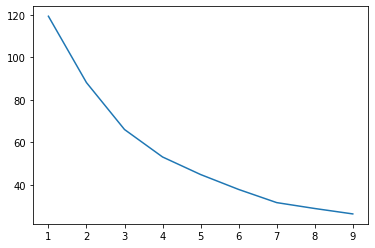

In [47]:
ax = sns.lineplot(x=np.arange(1, max_clusters) , y = sum_of_squared_distances)

With the RBF kernel, both 3 and 4 clusters seem like a good candidate.  

### Cluster Analysis

As we've explained in our related work, we're going to use RBF PCA to take advantage of its nonlinear dimensionality reduction

In [48]:
pca = KernelPCA(n_components=3, random_state=22, kernel='rbf')
km = KMeans(n_clusters=3, init="k-means++", n_init=50, max_iter=500, random_state=22)
clusterer = Pipeline([
           ('scaler', scaler),
           ('pca', pca),
           ('kmeans', km)])
_ = clusterer.fit(df)

In [53]:
cluster_df = df.copy().assign(Cluster=clusterer['kmeans'].labels_)
cluster_df.head()

,Satisfaction,Category,Incidence rate,R rate,Experience,Purchases,Total Complaints,Orders,Cluster
0,53.85000,1,49.0,0.90,1.20,49.0,0.0,0.0,0
1,100.00000,0,37.0,0.00,0.00,38.0,0.0,0.0,0
2,29.21872,1,33.0,1.53,0.00,34.0,0.0,0.0,0
3,29.21872,1,28.0,2.03,0.48,29.0,0.0,0.0,0
4,76.79000,1,23.0,0.96,0.75,24.0,0.0,0.0,0


In [52]:
cluster_df.groupby('Cluster').mean()

,Satisfaction,Category,Incidence rate,R rate,Experience,Purchases,Total Complaints,Orders
Cluster,,,,,,,,
0,-3.705100,0.892562,6.690909,1.113306,0.714050,17.628099,1.942149,1.785124
1,37.412995,0.921429,4.311071,1.746000,0.543214,8.764286,0.114286,0.085714
2,45.335673,0.738636,4.509034,0.573580,0.402955,7.704545,0.085227,0.102273


### Explain feature importance
We'll fit a PCA and extract pc1 of each cluster to determine the most important feature for each cluster

In [79]:
clusters = [cluster_df[cluster_df['Cluster'] == i] for i in range(3)]
pc1s = []
for i in range(3):
    pca = PCA(n_components=len(cluster_df.columns), random_state=22)
    pca.fit(clusters[i])
    pc1s.append(list(np.round(pca.components_[0], 2)))
    print('variance ratio: ', np.round(pca.explained_variance_ratio_, 2))
pprint(pc1s)

variance ratio:  [0.92 0.06 0.01 0.   0.   0.   0.   0.   0.  ]
variance ratio:  [0.96 0.04 0.   0.   0.   0.   0.   0.   0.  ]
variance ratio:  [0.96 0.03 0.   0.   0.   0.   0.   0.   0.  ]
[[0.99, 0.0, 0.03, 0.0, 0.0, 0.13, 0.01, 0.02, 0.0],
 [-1.0, -0.0, 0.0, 0.0, -0.0, 0.01, -0.0, -0.0, -0.0],
 [-1.0, 0.0, -0.0, -0.0, -0.0, -0.03, 0.0, 0.0, -0.0]]


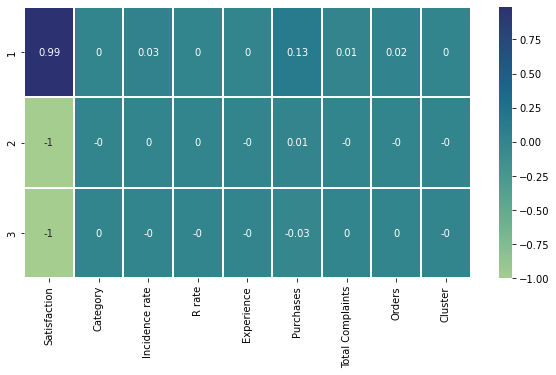

In [80]:
plt.figure(figsize=(10, 5))
ax = sns.heatmap(pd.DataFrame(pc1s, columns=cluster_df.columns, index=['1', '2', '3']), cmap="crest", annot=True, linewidth=2)

We see that satisfaction is one of the most defining characteristic in each cluster

Let's use OLS to see which feature is most correlated with purchases in each cluster

## Results

## Discussion/Conclusion